In [1]:
import xarray as xr
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.stats import gaussian_kde

from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import linregress


from utils import list_folders_with_prefix, list_csv_files_in_folder,read_csv_file_with_station_name
from utils import select_rename_convert_to_xarray


In [2]:
file_path_station_info = "/home/khanalp/code/PhD/preprocessICOSdata/output/csvs/stations_readyformodelrun.csv"
input_data_path_flux = "/home/khanalp/data/ICOS2020"
prefix = "FLX"
pystemmus_output_model_path = "/home/khanalp/STEMMUSSCOPE/STEMMUS_SCOPE/ICOS_sites/"
plumber2_output_location = "/home/khanalp/data/plumber2output"

In [3]:
# List folders and CSV files 
folders = list_folders_with_prefix(input_data_path_flux, prefix)
csv_files = []
for folder in folders:
    folder_path = os.path.join(input_data_path_flux, folder)
    csv_files.extend(list_csv_files_in_folder(folder_path, "FULLSET_HH"))

In [4]:
# Assuming "Station_name" is the column containing station names
stations_to_plot = ["DK-Sor","BE-Lon","DE-Geb","FR-Fon","FR-Gri"]

In [5]:
selected_variables = [
    'TIMESTAMP_START',
    'NETRAD',
    #'SW_OUT',
    'G_F_MDS',
    'LE_CORR',
    'H_CORR',
    'LE_CORR_JOINTUNC',
    'H_CORR_JOINTUNC',
    'USTAR',
    'NEE_VUT_REF',
    'NEE_VUT_REF_JOINTUNC',
    'GPP_NT_VUT_REF',
    'GPP_NT_VUT_SE',
    'GPP_DT_VUT_REF',
    'GPP_DT_VUT_SE',
    'RECO_NT_VUT_REF',
    'RECO_NT_VUT_SE'
]

In [6]:
#Renaming them 
rename_mapping = {'NETRAD':'Rnet',
          #'SW_OUT':'SWup',
          'G_F_MDS':'Qg',
          'LE_CORR':'Qle',
          'H_CORR':'Qh',
          'LE_CORR_JOINTUNC':'Qle_cor_uc',
          'H_CORR_JOINTUNC':'Qh_cor_uc',
          'USTAR':'Ustar',
          'NEE_VUT_REF':'NEE',
          'NEE_VUT_REF_JOINTUNC' : 'NEE_uc',
          'GPP_NT_VUT_REF':'GPP',
          'GPP_NT_VUT_SE':'GPP_se',
          'GPP_DT_VUT_REF':'GPP_DT',
          'GPP_DT_VUT_SE':'GPP_DT_se',
          'RECO_NT_VUT_REF':'Resp',
          'RECO_NT_VUT_SE':'Resp_se'
         }


In [8]:
variables_to_plot = ['Rnet','Qg','Qh','Qle','GPP','NEE']
    
# Define the units and titles for each variable
variable_info = {
    'Rnet': {'title': 'Net Radiation', 'unit': 'W/sq.m'},
    'Qg': {'title': 'Ground Heat Flux', 'unit': 'W/sq.m'},
    'Qh': {'title': 'Sensible Heat Flux', 'unit': 'W/sq.m'},
    'Qle': {'title': 'Latent Heat Flux', 'unit': 'W/sq.m'},
    'GPP': {'title': 'Gross Primary Productivity', 'unit': 'kg/sq.m/s'},
    'NEE': {'title': 'Net Ecosystem Exchange', 'unit': 'kg/sq.m/s'}
}

DK-Sor


<Figure size 640x480 with 0 Axes>

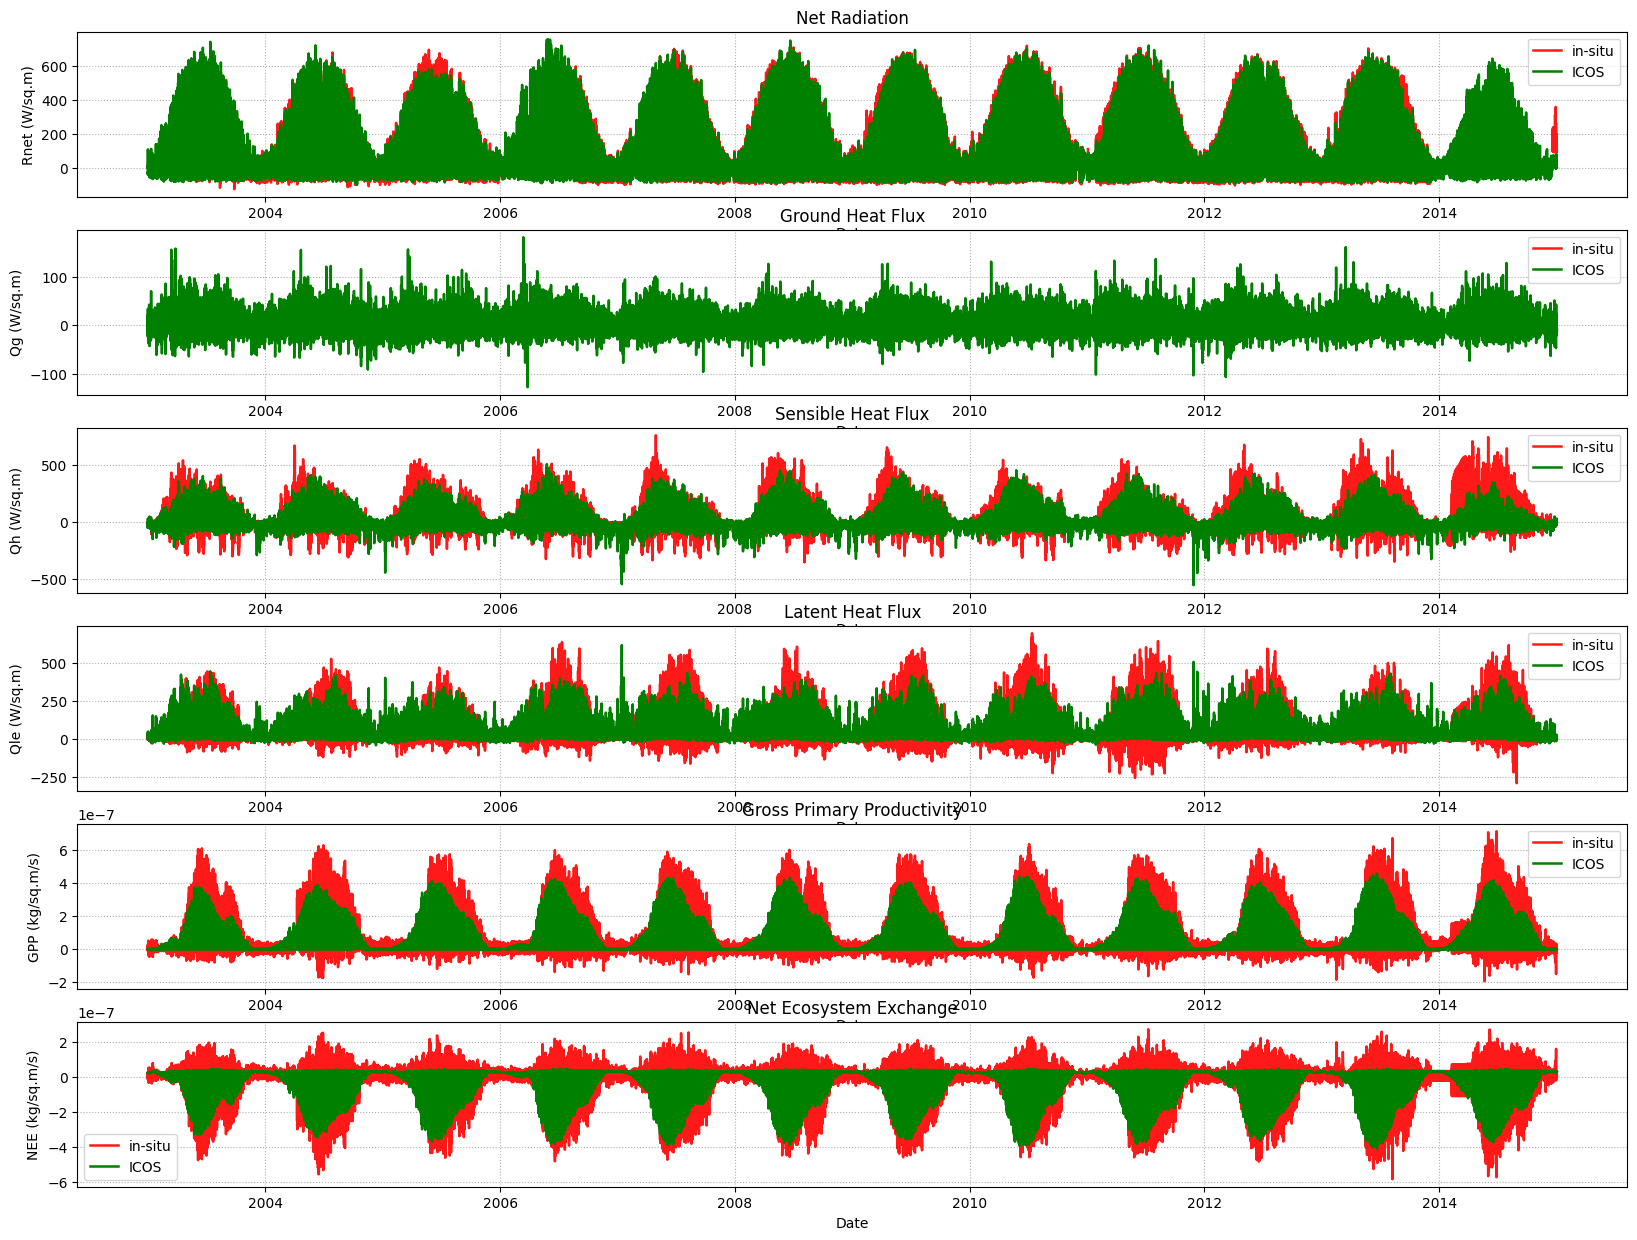

In [25]:
for station in stations_to_plot:
    print(station)
    # ## Reading ICOS model output
    modeloutput_folder_path = os.path.join(pystemmus_output_model_path, station,"output")
    # Get the latest folder created
    latest_folder = max((entry.path for entry in os.scandir(modeloutput_folder_path) if entry.is_dir()), key=os.path.getctime)
    # Filter out NetCDF files
    nc_files = [file for file in os.listdir(latest_folder) if file.endswith('.nc')]
   
    try: 
        ICOS_output_nc = xr.open_dataset(os.path.join(latest_folder,nc_files[0]))
        plumber2_location = [file for file in os.listdir(plumber2_output_location) if file.endswith('.nc') and station in file]
        plumber2_output_nc =  xr.open_dataset(os.path.join(plumber2_output_location,plumber2_location[0]))
    except KeyError: 
         continue
        # Find the common time range
    common_time_min = max(ICOS_output_nc.time.min(), plumber2_output_nc.time.min())
    common_time_max = min(ICOS_output_nc.time.max(), plumber2_output_nc.time.max())

    # Slice both datasets to the common time range
    ICOS_output_nc_sliced = ICOS_output_nc.sel(time=slice(common_time_min, common_time_max))
    plumber2_output_nc_sliced = plumber2_output_nc.sel(time=slice(common_time_min, common_time_max))
    
    ## Reading insitu data 
    filtered_files = [file for file in csv_files if station in file]
    df_insitu_flux = pd.read_csv(filtered_files[0])
    #selecting required variables from ICOS data for input.
    # Check if 'NETRAD' is in the columns, if not, remove it from selected_variables
    if 'NETRAD' not in df_insitu_flux.columns:
        selected_variables = [var for var in selected_variables if var != 'NETRAD']
        
    insitu_data_nc_complete =  select_rename_convert_to_xarray(df_insitu_flux,selected_variables,rename_mapping)
    # Replace -9999 with NaN
    insitu_data_nc_complete = insitu_data_nc_complete.where(insitu_data_nc_complete != -9999, np.nan)


    # Truncate insitu_data_nc to match the maximum time of model_output_nc
    insitu_data_nc_sliced = insitu_data_nc_complete.sel(time=slice(common_time_min, common_time_max))
    
    # Assuming 'insitu_data_filled' is your xarray Dataset
    insitu_data_nc_sliced['GPP'] = xr.DataArray((insitu_data_nc_sliced['GPP'].values.flatten() * 1e-6 * 12.01 * 1e-3).reshape(1,1,-1),dims=['x','y','time'])
    insitu_data_nc_sliced['NEE'] = xr.DataArray((insitu_data_nc_sliced['NEE'].values.flatten() * 1e-6 * 12.01 * 1e-3).reshape(1,1,-1),dims=['x','y','time'])
    
    
    plt.clf()
    # Calculate the number of rows and columns for subplots
    num_plots_line = len(variables_to_plot)
    num_rows_line = num_plots_line
    num_cols_line = 1
    
        # Create subplots
    fig, axes = plt.subplots(num_rows_line, num_cols_line, figsize=(20, 2.5 * num_rows_line))

    # Flatten the axes array for easier iteration
    axes_flat = axes.flatten()
            
    # Plot the variable
    for i,var in enumerate(variables_to_plot):
        # Get the subplot for the current variable
        ax = axes_flat[i]
        try:
            # Plot insitu data
            ax.plot(insitu_data_nc_sliced.time.values.flatten(), insitu_data_nc_sliced[var].values.flatten(),
                    linestyle='-',
                    linewidth=1.8,
                    color='red',
                    label='in-situ', 
                    alpha = 0.9 )
        except KeyError:
            print(f"Insitu data for variable '{var}' not available.")
        # try:
        #     # Plot model data
        #     ax.plot(plumber2_output_nc_sliced.time.values.flatten(), plumber2_output_nc_sliced[var].values.flatten(),
        #             linestyle='-',
        #             linewidth=1.8,
        #             color='blue',
        #             label='plumber2')
        # except KeyError:
        #     print(f"Model run (plumber2) data for variable '{var}' not available.")
        try:
            # Plot model data
            ax.plot(ICOS_output_nc_sliced.time.values.flatten(), ICOS_output_nc_sliced[var].values.flatten(),
                    linestyle='-',
                    linewidth=1.8,
                    color='green',
                    label='ICOS')
        except KeyError:
            print(f"Model run (ICOS) data for variable '{var}' not available.")
    
        # Set the title, xlabel, ylabel, and grid
        ax.set_title(f"{variable_info[var]['title']}")
        ax.set_xlabel("Date")
        ax.set_ylabel(f"{var} ({variable_info[var]['unit']})")
        ax.grid(linestyle='dotted')

        # Add legend
        ax.legend()
            
        # Adjust the space between subplots
    # plt.suptitle(f"Comparison between ICOS, Plumber2 model runs and In-situ data for {station}")
    # plt.subplots_adjust(hspace=0.75) 
    # # plt.suptitle(f"Comparison between PyStemmusscope and In-situ data for {station} ({igpb})")
    # # Save the plot with the station name as the filename
    # plt.savefig(os.path.join("/home/khanalp/code/PhD/preprocessICOSdata/output/plot/comparisonICOSPlumber2/outputs", f"{station}_comparison.png"), dpi=300)
    break
    # Show the plot
    

In [21]:
insitu_data_nc_sliced

<xarray.Dataset>
Dimensions:     (x: 1, y: 1, time: 210384)
Coordinates:
  * x           (x) float64 1.0
  * y           (y) float64 2.0
  * time        (time) datetime64[ns] 2003-01-01 ... 2014-12-31T23:30:00
Data variables: (12/15)
    Rnet        (x, y, time) float64 nan nan nan nan nan ... 96.0 94.8 94.3 97.0
    Qg          (x, y, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    Qle         (x, y, time) float64 -0.1259 0.6646 -0.03588 ... -1.789 -0.6355
    Qh          (x, y, time) float64 -0.6628 -9.621 -7.245 ... -4.017 -1.824
    Qle_cor_uc  (x, y, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    Qh_cor_uc   (x, y, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    ...          ...
    GPP         (x, y, time) float64 -8.829e-10 3.422e-10 ... -1.037e-09
    GPP_se      (x, y, time) float64 0.008597 0.007433 ... 0.0002951 0.002841
    GPP_DT      (x, y, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    GPP_DT_se   (x, y, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Resp        (x, y, time) float64 1.433 1.437 1.39 1.39 ... 1.138 1.116 1.126
    Resp_se     (x, y, time) float64 0.008906 0.008907 ... 0.0002951 0.0001859